In [1]:
import os
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# **Assignment #1**: making new Layers and Models via subclassing
Building a ResNet18 architecture leveraging tf.keras.Model subclassing



### ResNet block: the residual layer

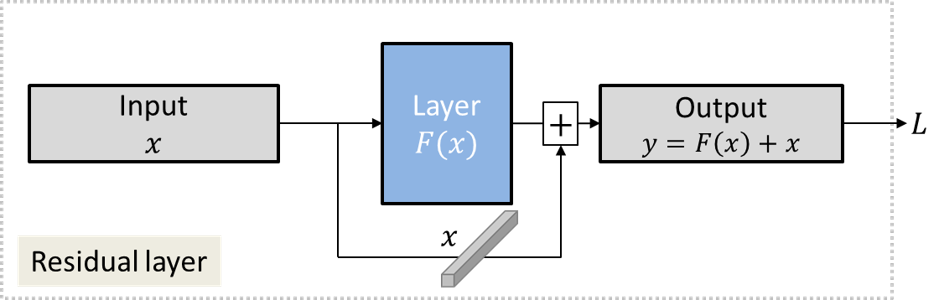

Notes:
*   **Batch normalization** is implemented right after each convolution and before activation
*   If the **input dimension has the same dimension as the output** the block implements an identity function 
*   **Otherwise** in the skip connection we insert a 1x1 convolutional block

In [2]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [3]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

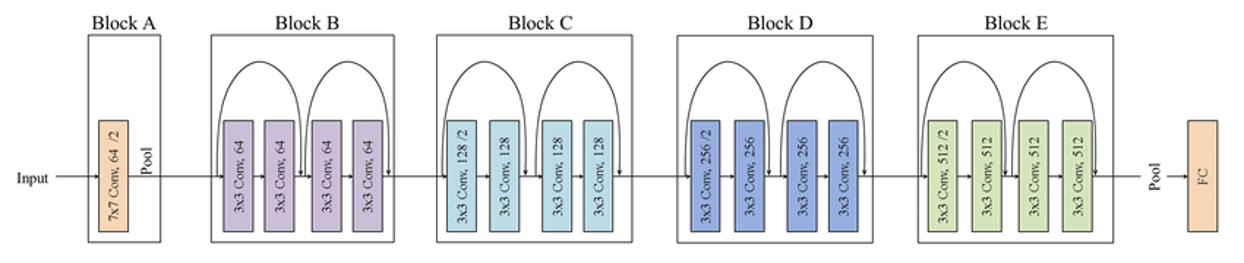

## ResNet18

In [4]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

# Dataset

The `tf.data` API allows you to construct, manage and reuse efficient and complex input pipelines.

Specifically, the `tf.data.Dataset` abstraction represents a sequence of elements, in which *each element is made up of one or more components*. For instance, in an image processing pipeline, an element is a single training example, consisting in a pair of tensor components: the image and its label.

The typical pattern for `tf.data.Dataset` usage is the following:

    Create a source dataset from your input data (from data stored in memory).
    Apply dataset transformations to preprocess the data.
    Iterate over the dataset and process the elements.

Read carefully the official [tf.data guide](https://www.tensorflow.org/guide/data). 

## TensorFlow Datasets (TFDS)

TFDS is a high level wrapper around `tf.data` which provides a collection of ready-to-use datasets.

In [5]:
(mnist_train, mnist_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


`tf.data.Dataset` objects can be converted to `pandas.DataFrame` with tfds.as_dataframe to be visualized on Colab.

In [6]:
tfds.as_dataframe(mnist_train.take(4), ds_info)

,image,label
0,,4
1,,1
2,,0
3,,7


`tfds.show_examples` returns a matplotlib.figure

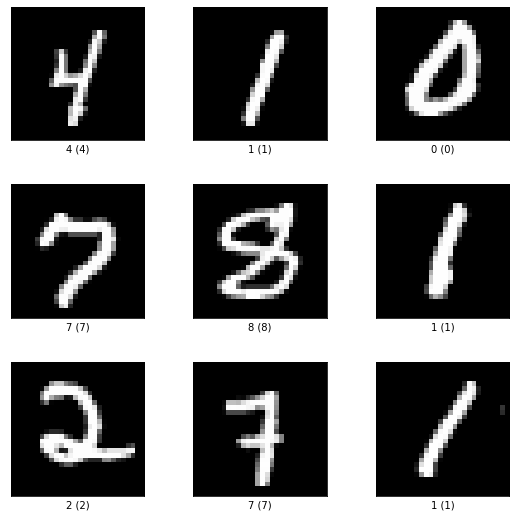

In [7]:
fig = tfds.show_examples(mnist_train, ds_info)

## Map method

In [8]:
def process_data(image, label):
  return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

mnist_train = mnist_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(ds_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

N.B. Do not shuffle test dataset

In [9]:
mnist_test = mnist_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

## Train and test on MNIST

In [10]:
net = ResNet()
net.build((1, 28, 28, 1))
net.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net.fit(mnist_train, epochs=3)
print("Accuracy on test set: {:.2f}".format(net.evaluate(mnist_test)[1]))
preds_mnist = net.predict(mnist_test)

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 7, 7, 64)             3456      
                                                                 
 resnet_block (ResnetBlock)  multiple                  148736    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 526976    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple                 2102528   
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  multiple                 8399360   
 )                                                               
                                                           

# Uncertainty in DL - MC Dropout
## Defining **self-awarness** is ambiguous even for human-beings. A rudimentary kind of self-awarness, easier to catch is the **ability to know what you don't know**.

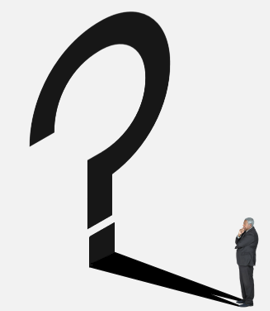

## **Assignment #2**: Code a MC Dropout-based version of ResNet18

In [11]:
class ResNetMC(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(ResNetMC, self).__init__()
        self.mc_dropout = mc_dropout
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        if self.mc_dropout:
            print("MC Dropout is active")
        x = self.block_a(inputs)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_b(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_c(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_d(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_e(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.global_pool(x)
        return self.classifier(x)

## Load EMNIST

In [12]:
def show_images_from_npy(array, cmap=None):
    fig, ax = plt.subplots(1, 5)
    ax = ax.ravel()
    j = 0
    for idx in np.random.randint(0, array.shape[0], 5):
        ax[j].imshow(array[idx], cmap=cmap)
        ax[j].axis('off')
        j += 1

emnist = np.load("/content/drive/MyDrive/Teaching&Thesis/Theaching_dataset/emnist_images.npy")
emnist_numpy = (emnist / 255).astype(np.float32)

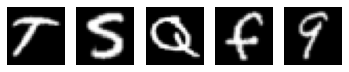

In [13]:
show_images_from_npy(emnist_numpy, cmap="gray")

N.B. Do not shuffle emnist

In [14]:
emnist = tf.data.Dataset.from_tensor_slices((np.expand_dims(emnist_numpy, axis=-1), np.zeros((len(emnist_numpy)))))
emnist = emnist.cache()
emnist = emnist.batch(128)
emnist = emnist.prefetch(tf.data.AUTOTUNE)
preds_emnist = net.predict(emnist)

## **Assignment #3**: Code a wrapper for a MC-based network
Implements:
1.   Several metrics to compute uncertainty
2.   Method to reierate predictions


In [15]:
class UncertaintyWrapper(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(UncertaintyWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetMC(mc_dropout=mc_dropout)
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

In [16]:
net_unc = UncertaintyWrapper(mc_dropout=0.1)
net_unc.build((1, 28, 28, 1))
net_unc.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_unc.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net_unc.fit(mnist_train, epochs=1)
print("Accuracy on test set: {:.2f}".format(net_unc.evaluate(mnist_test)[1]))

MC Dropout is set to 0.1
MC Dropout is active
Model: "uncertainty_wrapper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_mc (ResNetMC)       multiple                  11186186  
                                                                 
Total params: 11,186,186
Trainable params: 11,178,378
Non-trainable params: 7,808
_________________________________________________________________
MC Dropout is active
MC Dropout is active
469/469 [==============================] - 37s 73ms/step - loss: 0.2697 - accuracy: 0.9144
MC Dropout is active
79/79 [==============================] - 2s 19ms/step - loss: 0.1597 - accuracy: 0.9504
Accuracy on test set: 0.95


## Compute MC predicitons and compare with *deterministic* uncertainty computation

In [17]:
multiple_preds_emnist = net_unc.predict_many_times(emnist, draws=10)
multiple_preds_mnist = net_unc.predict_many_times(mnist_test, draws=10)

MC Dropout is active
MC Dropout is active


In [18]:
uncertainties = dict()
uncertainties_deterministic = dict()
uncertainties['mnist'] = net_unc.uncertainty_metrics(multiple_preds_mnist)
uncertainties['emnist'] = net_unc.uncertainty_metrics(multiple_preds_emnist)
uncertainties_deterministic['mnist'] = net_unc.uncertainty_metrics(preds_mnist)
uncertainties_deterministic['emnist'] = net_unc.uncertainty_metrics(preds_emnist)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


## **Assignment #4** Uncertainty metrics distributions for MNIST and EMNIST
Plot distributions in form of histograms


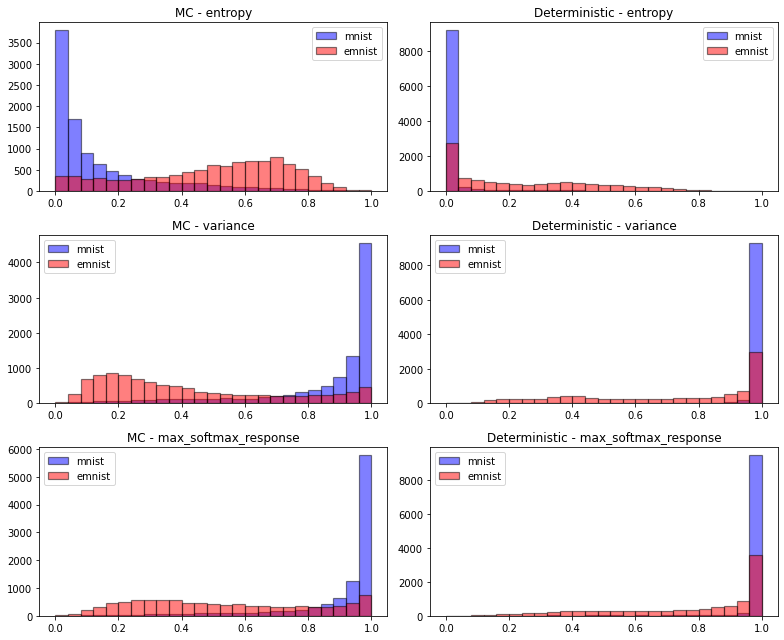

In [19]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 2, figsize=(11, 9))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
plt.tight_layout()

## **Assignment #5** Take a look at confident and not-confident predictions for EMNIST
Filter confident and not-confident images based on uncertainty values and plot some of them

In [20]:
n_examples = 5
emnist_confident = emnist_numpy[uncertainties['emnist']['variance'] >= 0.95]
emnist_not_confident = emnist_numpy[uncertainties['emnist']['variance'] < 0.1]

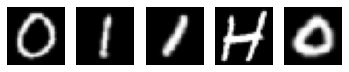

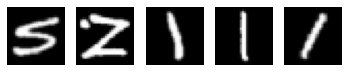

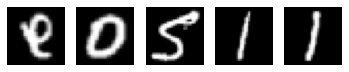

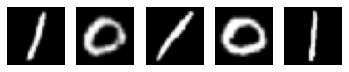

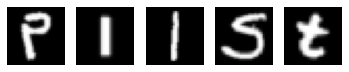

In [21]:
for _ in range(n_examples):
    show_images_from_npy(emnist_confident, cmap="gray")

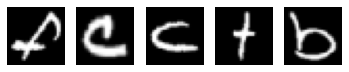

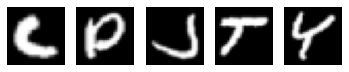

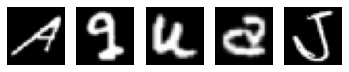

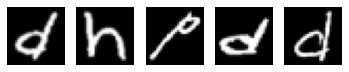

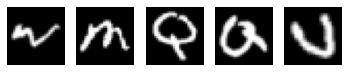

In [22]:
for _ in range(n_examples):
    show_images_from_npy(emnist_not_confident, cmap="gray")

# Uncertainty in DL - Ensamble

In [ ]:
nets = list()
for _ in range(5):
    net = ResNet()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
    net.fit(mnist_train, epochs=3)
    nets.append(net)

Epoch 1/3
469/469 [==============================] - 36s 71ms/step - loss: 0.1310 - accuracy: 0.9592
Epoch 2/3
469/469 [==============================] - 33s 71ms/step - loss: 0.0362 - accuracy: 0.9885
Epoch 3/3
469/469 [==============================] - 33s 71ms/step - loss: 0.0174 - accuracy: 0.9945
Epoch 1/3
469/469 [==============================] - 35s 71ms/step - loss: 0.1279 - accuracy: 0.9602
Epoch 2/3
469/469 [==============================] - 34s 72ms/step - loss: 0.0350 - accuracy: 0.9889
Epoch 3/3
469/469 [==============================] - 33s 71ms/step - loss: 0.0158 - accuracy: 0.9954
Epoch 1/3
469/469 [==============================] - 36s 72ms/step - loss: 0.1344 - accuracy: 0.9585
Epoch 2/3
469/469 [==============================] - 33s 71ms/step - loss: 0.0362 - accuracy: 0.9885
Epoch 3/3
469/469 [==============================] - 33s 71ms/step - loss: 0.0169 - accuracy: 0.9947
Epoch 1/3
469/469 [==============================] - 35s 71ms/step - loss: 0.1377 - accurac

In [ ]:
import pickle
with open("ensamble.pickle", "wb") as fp:
    pickle.dump(nets, fp)

In [ ]:
emnist_preds_ensamble = list()
mnist_preds_ensamble = list()
for net in nets:
    emnist_preds_ensamble.append(net.predict(emnist))
    mnist_preds_ensamble.append(net.predict(mnist_test))

In [ ]:
uncertainties_ensable = dict()
uncertainties_ensable['mnist'] = net_unc.uncertainty_metrics(np.array(mnist_preds_ensamble))
uncertainties_ensable['emnist'] = net_unc.uncertainty_metrics(np.array(emnist_preds_ensamble))

In [ ]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 3, figsize=(16, 13))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
plt.tight_layout()

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
NUM_TRAIN_EXAMPLES = 50000
NUM_CLASSES = 10
LR = 0.01

# Uncertainty in DL - Variational Inference

In [ ]:
class ResidualVI(tf.keras.Model):
    """The Residual block of ResNet."""
    
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                                       tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))
        self.conv1 = tfp.layers.Convolution2DFlipout(
            num_channels, 
            kernel_size=3, 
            padding='same',
            strides=strides,
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv2 = tfp.layers.Convolution2DFlipout(
            num_channels, 
            kernel_size=3, 
            padding='same',
            kernel_divergence_fn=self.kl_divergence_function,
            activation=tf.nn.relu)
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
            
            self.conv_1x1 = tfp.layers.Convolution2DFlipout(
                num_channels, 
                kernel_size=1, 
                strides=strides,
                kernel_divergence_fn=self.kl_divergence_function)

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlockVI(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlockVI, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    ResidualVI(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(ResidualVI(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

class ResNetVI(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNetVI, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlockVI(64, 2, downscale=False)
        self.block_c = ResnetBlockVI(128, 2)
        self.block_d = ResnetBlockVI(256, 2)
        self.block_e = ResnetBlockVI(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

In [ ]:
def create_model():
  """Creates a Keras model using the LeNet-5 architecture.
  Returns:
      model: Compiled Keras model.
  """
  # KL divergence weighted by the number of training samples, using
  # lambda function to pass as input to the kernel_divergence_fn on
  # flipout layers.
  kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

  # Define a LeNet-5 model using three convolutional (with max pooling)
  # and two fully connected dense layers. We use the Flipout
  # Monte Carlo estimator for these layers, which enables lower variance
  # stochastic gradients than naive reparameterization.
  model = tf.keras.models.Sequential([
      tfp.layers.Convolution2DFlipout(
          6, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          16, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(
          pool_size=[2, 2], strides=[2, 2],
          padding='SAME'),
      tfp.layers.Convolution2DFlipout(
          120, kernel_size=5, padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tf.keras.layers.Flatten(),
      tfp.layers.DenseFlipout(
          84, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu),
      tfp.layers.DenseFlipout(
          NUM_CLASSES, kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.softmax)
  ])
  return model

In [ ]:
class VIWrapper(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(VIWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetVI()
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: net_unc._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

In [ ]:
net_vi = VIWrapper()
# Model compilation.
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
# We use the categorical_crossentropy loss since the MNIST dataset contains
# ten labels. The Keras API will then automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
net_vi.compile(optimizer, loss='categorical_crossentropy',
               metrics=['accuracy'], experimental_run_tf_function=False)

In [ ]:
net_vi.fit(mnist_train, epochs=3)

In [ ]:
print("Accuracy on test set: {:.2f}".format(net_vi.evaluate(mnist_test)[1]))
preds_mnist = net_vi.predict(mnist_test)

In [ ]:
vi_preds_emnist = net_vi.predict_many_times(emnist, draws=10)
vi_preds_mnist = net_vi.predict_many_times(mnist_test, draws=10)

In [ ]:
uncertainties_vi = dict()
uncertainties_vi['mnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_mnist))
uncertainties_vi['emnist'] = net_unc.uncertainty_metrics(np.array(vi_preds_emnist))

In [ ]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 4, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3] .set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
plt.tight_layout()

# Uncertainty in DL - Test Time Augmentation-Based

In [ ]:
class TTAWrapper(UncertaintyWrapper):
    def __init__(self, num_classes=10):
        super(TTAWrapper, self).__init__()
        self.model = ResNet()
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()

        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(15, 15),
                tf.keras.layers.Resizing(28, 28)])]

        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal")])
        ]

        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(repeat)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(repeat)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(repeat)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(repeat)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.predict(ds_augmented))

        return pred_augmented

In [ ]:
net_tta = TTAWrapper()
net_tta.build((1, 28, 28, 1))
net_tta.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_tta.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net_tta.fit(mnist_train, epochs=3)
print("Accuracy on test set: {:.2f}".format(net_tta.evaluate(mnist_test)[1]))

In [ ]:
emnist_preds_tta = net_tta.predict_many_times(emnist, "random_zoom", repeat=4)
mnist_preds_tta = net_tta.predict_many_times(mnist_test, "random_zoom", repeat=4)

In [ ]:
uncertainties_tta = dict()
uncertainties_tta['mnist'] = net_tta.uncertainty_metrics(np.array(mnist_preds_tta))
uncertainties_tta['emnist'] = net_tta.uncertainty_metrics(np.array(emnist_preds_tta))
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 5, figsize=(21, 11))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
    ax[2] .set_title(f"Ensamble - {measure}")
    ax[2].hist(uncertainties_ensable['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[2].hist(uncertainties_ensable['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[2].legend()
    ax[3] .set_title(f"VI - {measure}")
    ax[3].hist(uncertainties_vi['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[3].hist(uncertainties_vi['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[3].legend()
    ax[4].set_title(f"TTA - {measure}")
    ax[4].hist(uncertainties_tta['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[4].hist(uncertainties_tta['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[4].legend()
plt.tight_layout()

The subfield dealing with such abilities in machine learning goes under the name of **selective prediction** (a.k.a. prediction with a reject option). The main aim of selective prediction is to reduce the error rate by avoid furnishing doubtful predictions. The ultimate goal of selective prediction is building a classifier able to abstain from giving unconfident predicitons (which should be guaranteed with high probability), while keeping the **coverage** of the classifier as high as possible.